# Model Selection and Regularization (Seleção de Modelos e Regularização)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Seleção de Subconjuntos
  * Melhor Seleção de Subconjunto
  * Forward Stepwise Selection (Seleção passo a passo para frente)
  * Backward Stepwise Selection (Seleção passo a passo para trás)
* Escolhendo o modelo ideal
* Validação e Validação Cruzada
* Shrinkage Methods (Métodos de Encolhimento)
  * Ridge Regression
  * Trade-off de viés-variância
  * Lasso
  * Comparando a regressão Lasso e Ridge
  * Selecionando o parâmetro de ajuste

### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 5***
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman : 
  * Capítulo 7

***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

### 1. Introdução

Quando falamos de big data, não falamos apenas de tamanho de amostra maior,
, mas também sobre um maior número de variáveis ​​explicativas,
. No entanto, com os mínimos quadrados ordinários, somos limitados pela restrição de identificação que
. Além disso, para precisão de inferência e previsão, gostaríamos de ter«
.

Esta sessão aborda métodos para usar um ajuste de mínimos quadrados em um cenário em que o número de regressores,
, é grande em relação ao tamanho da amostra,

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import
import pandas as pd
import numpy as np
import time
import itertools
import statsmodels.api as sm
import seaborn as sns

from numpy.random import normal, uniform
from itertools import combinations
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.model_selection import KFold, cross_val_score, train_test_split, LeaveOneOut, ShuffleSplit
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

### 2. Seleção de Subconjuntos

A abordagem de seleção de subconjunto envolve a identificação de um subconjunto do
preditores que acreditamos estar relacionados à resposta. Em seguida, ajustamos um modelo usando mínimos quadrados no conjunto reduzido de variáveis.

Vamos carregar o credit ratingconjunto de dados.

In [4]:
# Credit ratings dataset
credit = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Credit.csv', usecols=list(range(1,12)))
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Vamos analisar a relação entre características individuais e conta Balanceno Creditconjunto de dados.

In [5]:
# X and y
X = credit.loc[:, credit.columns != 'Balance']
y = credit.loc[:,'Balance']

### 2.1. Melhor Seleção de Subconjunto

Para realizar a melhor seleção de subconjunto, ajustamos uma regressão de mínimos quadrados separada para cada combinação possível de
preditores. Ou seja, ajustamos todos
modelos que contêm exatamente um preditor, todos
modelos que contêm exatamente dois preditores, e assim por diante. Em seguida, analisamos todos os modelos resultantes, com o objetivo de identificar o melhor.

Claramente, a principal desvantagem da melhor seleção de subconjunto é o poder computacional.

In [6]:
def model_selection(X, y, *args):
    """
    Função para seleção de modelo avaliando diferentes combinações de variáveis.

    Parâmetros:
    - X: DataFrame com variáveis explicativas.
    - y: Série ou array com variável dependente.
    - *args: funções que recebem um modelo ajustado e retornam um score (e.g., RSS, R²).

    Retorno:
    - Lista de arrays, cada um com colunas: [número de variáveis, valor da métrica]
    """
    
    # Inicializa listas para armazenar os scores
    scores = list(itertools.repeat(np.zeros((0, 2)), len(args)))

    # Variáveis categóricas a serem convertidas em dummies
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Número total de variáveis
    K = np.shape(X)[1]

    # Loop sobre o número de variáveis a serem incluídas (de 0 até K)
    for k in range(K + 1):
        print(f"Computing k={k}", end="")

        # Todas as combinações possíveis de k variáveis
        for i in combinations(range(K), k):

            # Subconjunto de variáveis
            X_subset = X.iloc[:, list(i)].copy()

            # Tratamento de variáveis categóricas
            if k > 0:
                categ_subset = list(categ_cols & set(X_subset.columns))
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Conversão para float para evitar erro no statsmodels
            if k > 0:
                X_subset = X_subset.astype(float)
            
            # Adiciona constante
            X_reg = add_constant(X_subset, has_constant='add') if k > 0 else np.ones((len(y), 1))

            # Ajusta modelo
            reg = OLS(y, X_reg).fit()

            # Calcula e armazena as métricas
            for j, metric in enumerate(args):
                score = np.reshape([k, metric(reg)], (1, -1))
                scores[j] = np.append(scores[j], score, axis=0)
        
        print("", end="\r")

    return scores

Vamos considerar 10 variáveis ​​e duas métricas de diferença: a Soma dos Resíduos dos Quadrados e $R^{2}$.

In [7]:
# Set metrics
rss = lambda reg : reg.ssr
r2 = lambda reg : reg.rsquared

# Compute scores
scores = model_selection(X, y, rss, r2)
ms_RSS = scores[0]
ms_R2 = scores[1]

In [8]:
# Save best scores
K = np.shape(X)[1]
ms_RSS_best = [np.min(ms_RSS[ms_RSS[:,0]==k,1]) for k in range(K+1)]
ms_R2_best = [np.max(ms_R2[ms_R2[:,0]==k,1]) for k in range(K+1)]

Vamos traçar as melhores pontuações.

In [9]:
# Figure 6.1
def make_figure_6_1():

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.1: Best Model Selection')

    # RSS
    ax1.scatter(x=ms_RSS[:,0], y=ms_RSS[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax1.plot(range(K+1), ms_RSS_best, c='r');
    ax1.scatter(np.argmin(ms_RSS_best), np.min(ms_RSS_best), marker='x', s=300)
    ax1.set_ylabel('RSS');

    # R2
    ax2.scatter(x=ms_R2[:,0], y=ms_R2[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax2.plot(range(K+1), ms_R2_best, c='r');
    ax2.scatter(np.argmax(ms_R2_best), np.max(ms_R2_best), marker='x', s=300)
    ax2.set_ylabel('R2');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

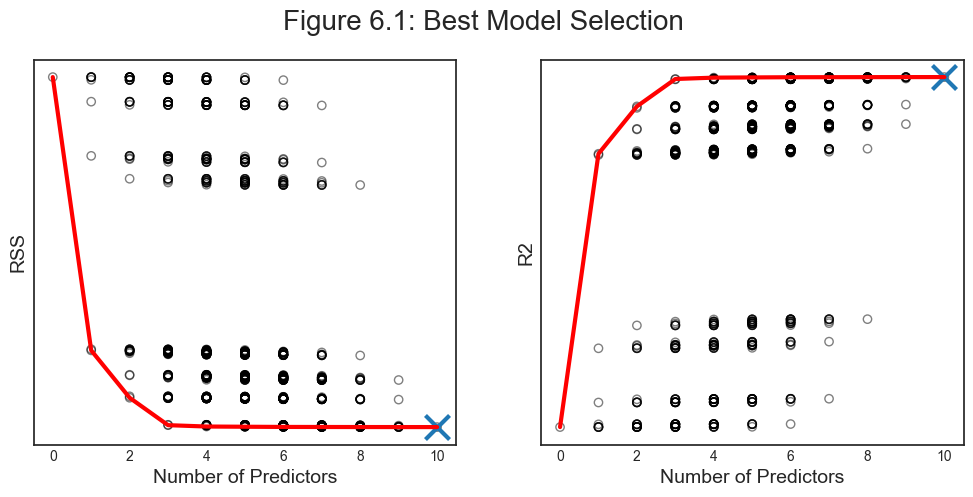

In [10]:
make_figure_6_1()

A figura mostra que, como esperado, ambas as métricas melhoram à medida que o número de variáveis ​​aumenta; no entanto, a partir do modelo de três variáveis, há pouca melhoria no RSS e $R^{2}$ como resultado da inclusão de preditores adicionais.

### 2.2. Forward Stepwise Selection (Seleção passo a passo para frente)

Por razões computacionais, a melhor seleção de subconjunto não pode ser aplicada com grandes $p$.

Embora o melhor procedimento de seleção de subconjunto considere todos
Para modelos possíveis contendo subconjuntos dos p preditores, a seleção progressiva passo a passo considera um conjunto muito menor de modelos. A seleção progressiva passo a passo começa com um modelo sem preditores e, em seguida, adiciona preditores ao modelo, um de cada vez, até que todos os preditores estejam presentes no modelo. Em particular, a cada passo, a variável que proporciona a maior melhoria adicional ao ajuste é adicionada ao modelo.

In [11]:
def forward_selection(X, y, f):
    """
    Forward selection: adiciona uma variável de cada vez, escolhendo a que minimiza a função f.

    Parâmetros:
    - X: DataFrame com variáveis explicativas.
    - y: Série ou array com variável dependente.
    - f: função de avaliação do modelo (e.g., RSS).

    Retorno:
    - fms_scores: vetor com os melhores scores em cada passo.
    """
    
    # Inicializa RSS
    K = np.shape(X)[1]
    fms_scores = np.zeros((K,1))

    # Variáveis categóricas
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Lista de variáveis selecionadas
    selected_cols = []

    for k in range(1, K + 1):
        remaining_cols = [col for col in X.columns if col not in selected_cols]
        temp_scores = np.zeros((0,1))

        for col in remaining_cols:
            # Subset das variáveis
            X_subset = X.loc[:, selected_cols + [col]].copy()

            # Dummy encoding para categóricas
            categ_subset = list(categ_cols & set(X_subset.columns))
            if categ_subset:
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Conversão para float
            X_subset = X_subset.astype(float)

            # Adiciona constante
            X_reg = add_constant(X_subset, has_constant='add')

            # Regressão
            reg = OLS(y, X_reg).fit()

            # Avaliação
            temp_scores = np.append(temp_scores, f(reg))

        # Seleciona a melhor variável
        best_col = remaining_cols[np.argmin(temp_scores)]
        print(f"Selecionada: {best_col}")
        selected_cols += [best_col]
        fms_scores[k - 1] = np.min(temp_scores)

    return fms_scores

Vamos selecionar o melhor modelo de acordo, usando a soma dos resíduos quadrados como métrica.

Quais são as variáveis ​​mais importantes?

In [12]:
# Forward selection by RSS
rss = lambda reg : reg.ssr
fms_RSS = forward_selection(X, y, rss)

Selecionada: Rating
Selecionada: Income
Selecionada: Student
Selecionada: Limit
Selecionada: Cards
Selecionada: Age
Selecionada: Ethnicity
Selecionada: Gender
Selecionada: Married
Selecionada: Education


O que acontece se usarmos $R^{2}$ em vez de?

In [13]:
# Forward selection by R2
r2 = lambda reg : -reg.rsquared
fms_R2 = -forward_selection(X, y, r2)

Selecionada: Rating
Selecionada: Income
Selecionada: Student
Selecionada: Limit
Selecionada: Cards
Selecionada: Age
Selecionada: Ethnicity
Selecionada: Gender
Selecionada: Married
Selecionada: Education


Sem surpresa, ambos os métodos selecionam os mesmos modelos. Por quê? No final $R^{2}$ é apenas uma versão normalizada do RSS.

Vamos traçar as pontuações dos dois métodos, para diferentes números de preditores.

In [14]:
# New figure 1
def make_new_figure_1():

    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Forward Model Selection')

    # RSS
    ax1.plot(range(1,K+1), fms_RSS, c='r');
    ax1.scatter(np.argmin(fms_RSS)+1, np.min(fms_RSS), marker='x', s=300)
    ax1.set_ylabel('RSS');

    # R2
    ax2.plot(range(1,K+1), fms_R2, c='r');
    ax2.scatter(np.argmax(fms_R2)+1, np.max(fms_R2), marker='x', s=300)
    ax2.set_ylabel('R2');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

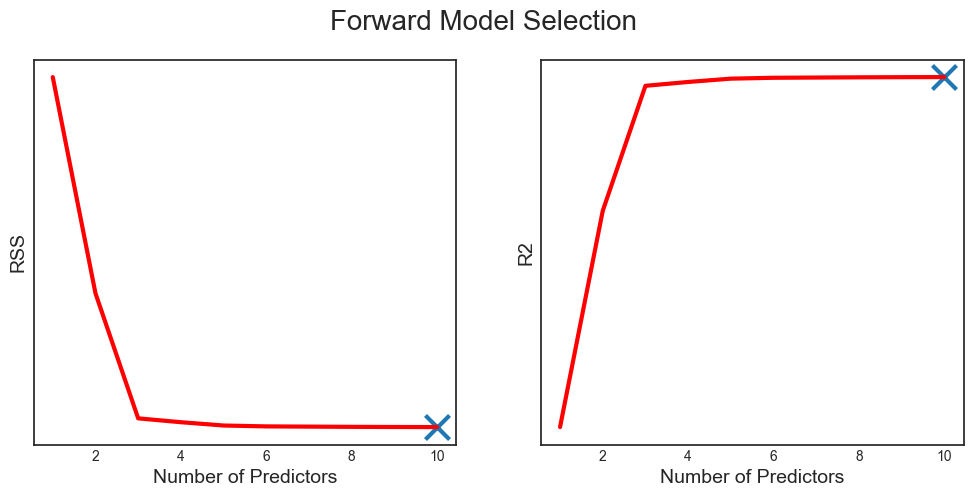

In [15]:
make_new_figure_1()

### 2.3. Backward Stepwise Selection (Seleção passo a passo para trás)

Assim como a seleção passo a passo para frente, a seleção passo a passo para trás oferece uma alternativa eficiente à seleção do melhor subconjunto. No entanto, diferentemente da seleção passo a passo para frente, ela começa com o modelo completo de mínimos quadrados contendo todos os p preditores e, em seguida, remove iterativamente o preditor menos útil, um de cada vez.

In [16]:
def backward_selection(X, y, f):
    """
    Backward selection: remove uma variável de cada vez, excluindo a que minimiza a função f.

    Parâmetros:
    - X: DataFrame com variáveis explicativas.
    - y: Série ou array com variável dependente.
    - f: função de avaliação do modelo (e.g., RSS).

    Retorno:
    - fms_scores: vetor com os melhores scores em cada passo.
    """
    
    # Inicializa RSS
    K = np.shape(X)[1]
    fms_scores = np.zeros((K,1))

    # Variáveis categóricas
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Lista inicial com todas as variáveis
    selected_cols = list(X.columns)

    for k in range(K, 0, -1):
        temp_scores = np.zeros((0,1))

        for col in selected_cols:
            # Subset removendo uma variável
            X_subset = X.loc[:, [x for x in selected_cols if x != col]].copy()

            # Dummy encoding para categóricas
            categ_subset = list(categ_cols & set(X_subset.columns))
            if categ_subset:
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Conversão para float
            X_subset = X_subset.astype(float)

            # Adiciona constante
            X_reg = add_constant(X_subset, has_constant='add')

            # Regressão
            reg = OLS(y, X_reg).fit()

            # Avaliação
            temp_scores = np.append(temp_scores, f(reg))

        # Identifica a pior variável (que ao ser removida melhora a métrica)
        worst_col = selected_cols[np.argmin(temp_scores)]
        print(f"Removida: {worst_col}")

        # Remove a variável
        selected_cols.remove(worst_col)

        # Armazena o melhor score
        fms_scores[k - 1] = np.min(temp_scores)

    return fms_scores

Vamos selecionar o melhor modelo de acordo, usando a soma dos resíduos quadrados como métrica.

Quais são as variáveis ​​mais importantes?

In [17]:
# Backward selection by RSS
rss = lambda reg : reg.ssr
bms_RSS = backward_selection(X, y, rss)

Removida: Education
Removida: Married
Removida: Gender
Removida: Ethnicity
Removida: Age
Removida: Rating
Removida: Cards
Removida: Student
Removida: Income
Removida: Limit


E se usássemos o $R^{2}$?

In [18]:
# Backward selection by R2
r2 = lambda reg : -reg.rsquared
bms_R2 = -backward_selection(X, y, r2)

Removida: Education
Removida: Married
Removida: Gender
Removida: Ethnicity
Removida: Age
Removida: Rating
Removida: Cards
Removida: Student
Removida: Income
Removida: Limit


A parte interessante aqui é que a variável `Rating` que foi selecionada primeiro pela seleção do modelo de avanço, agora é descartada $5^{th}$ para o último. Por quê? Provavelmente porque contém muitas informações por si só (daí o primeiro no FMS), mas é altamente correlacionado com Student, Incomee Limitembora essas variáveis ​​sejam mais ortogonais entre si, é descartado antes delas no BMS.

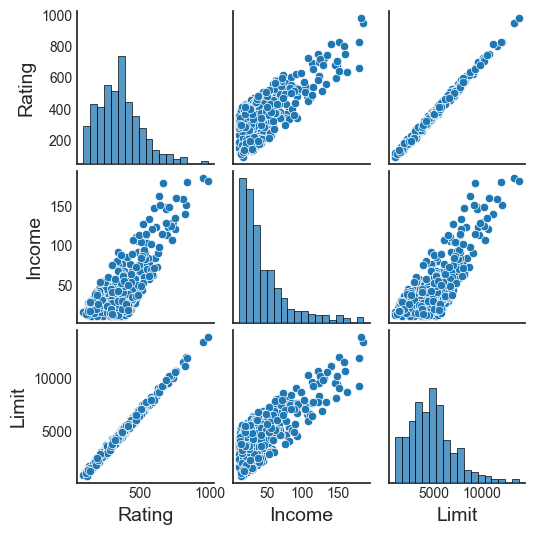

In [19]:
# Plot correlations
sns.pairplot(credit[['Rating','Student','Income','Limit']], height=1.8);


É de fato o que vemos: Ratinge Limitsão altamente correlacionados.

Vamos traçar as pontuações para diferentes números de preditores.

In [20]:
# New figure 2
def make_new_figure_2():

    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Backward Model Selection')

    # RSS
    ax1.plot(range(1,K+1), bms_RSS, c='r');
    ax1.scatter(np.argmin(bms_RSS)+1, np.min(bms_RSS), marker='x', s=300)
    ax1.set_ylabel('RSS');

    # R2
    ax2.plot(range(1,K+1), bms_R2, c='r');
    ax2.scatter(np.argmax(bms_R2)+1, np.max(bms_R2), marker='x', s=300)
    ax2.set_ylabel('R2');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

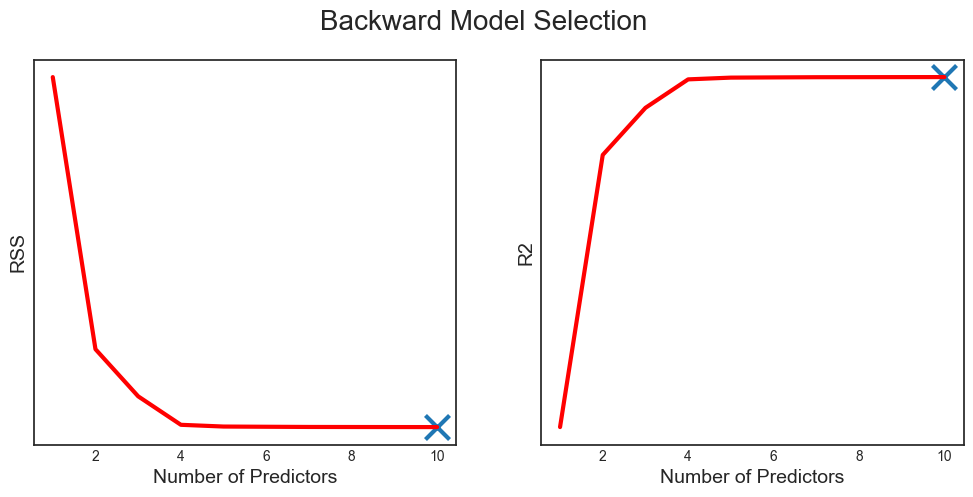

In [21]:
make_new_figure_2()

### 3. Escolhendo o modelo ideal

Até agora, utilizamos o erro de treinamento para selecionar o modelo. No entanto, o erro de treinamento pode ser uma estimativa ruim do erro de teste. Portanto, RSS e R² não são adequados para selecionar o melhor modelo entre um conjunto de modelos com diferentes números de preditores.

Para selecionar o melhor modelo em relação ao erro de teste, precisamos estimar esse erro. Existem duas abordagens comuns:

* Podemos estimar indiretamente o erro do teste fazendo um ajuste no erro de treinamento para levar em conta o viés devido ao overfitting.
* Podemos estimar diretamente o erro do teste usando uma abordagem de conjunto de validação ou uma abordagem de validação cruzada.

Algumas métricas que levam em conta o erro train int são

* ***Critério de Informação de Akaike (AIC)***
* ***Critério de Informação Bayesiano (BIC)***
* ***$R^{2}$ Ajustado***

A ideia por trás de todas essas variáveis ​​é inserir uma penalidade para o número de parâmetros usados ​​no modelo. Todas essas medidas têm fundamentos teóricos que estão além do escopo desta sessão.

Agora vamos testar as três métricas

In [22]:
# Set metrics
aic = lambda reg : reg.aic
bic = lambda reg : reg.bic
r2a = lambda reg : reg.rsquared_adj

# Compute best model selection scores
scores = model_selection(X, y, aic, bic, r2a)
ms_AIC = scores[0]
ms_BIC = scores[1]
ms_R2a = scores[2]

In [23]:
# Save best scores
ms_AIC_best = [np.min(ms_AIC[ms_AIC[:,0]==k,1]) for k in range(K+1)]
ms_BIC_best = [np.min(ms_BIC[ms_BIC[:,0]==k,1]) for k in range(K+1)]
ms_R2a_best = [np.max(ms_R2a[ms_R2a[:,0]==k,1]) for k in range(K+1)]

Traçamos as pontuações para diferentes métodos de seleção de modelos.

In [24]:
# Figure 6.2
def make_figure_6_2():

    # Init
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
    fig.suptitle('Figure 6.2')

    # AIC
    ax1.scatter(x=ms_AIC[:,0], y=ms_AIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax1.plot(range(K+1),ms_AIC_best, c='r');
    ax1.scatter(np.argmin(ms_AIC_best), np.min(ms_AIC_best), marker='x', s=300)
    ax1.set_ylabel('AIC');

    # BIC
    ax2.scatter(x=ms_BIC[:,0], y=ms_BIC[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax2.plot(range(K+1), ms_BIC_best, c='r');
    ax2.scatter(np.argmin(ms_BIC_best), np.min(ms_BIC_best), marker='x', s=300)
    ax2.set_ylabel('BIC');

    # R2 adj
    ax3.scatter(x=ms_R2a[:,0], y=ms_R2a[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax3.plot(range(K+1), ms_R2a_best, c='r');
    ax3.scatter(np.argmax(ms_R2a_best), np.max(ms_R2a_best), marker='x', s=300)
    ax3.set_ylabel('R2_adj');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

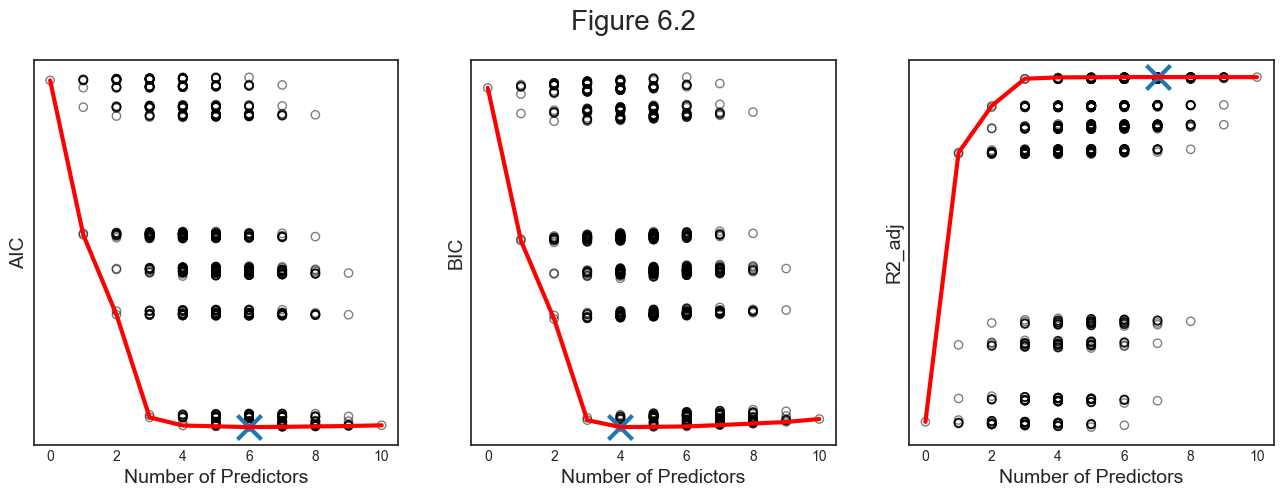

In [25]:
make_figure_6_2()

Como podemos ver, todas as três métricas selecionam modelos mais parcimoniosos, com o BIC sendo particularmente conservador com apenas 4 variáveis ​​e $R^{2}_{adj}$ selecionando o modelo maior com 7 variáveis.

### 4. Validação e Validação Cruzada

Como alternativa às abordagens discutidas, podemos estimar diretamente o erro do teste usando o conjunto de validação e os métodos de validação cruzada discutidos na sessão anterior.

O principal problema da validação cruzada é a carga computacional. Agora, realizaremos a seleção do melhor modelo usando os seguintes algoritmos de validação cruzada:

* Abordagem de conjunto de validação, divisão 50-50, repetida 10 vezes
* Validação cruzada de 5 vezes
* Validação cruzada de 10 vezes

Não realizaremos validação cruzada Leave-One-Out por razões computacionais.

In [26]:
def cv_scores(X, y, *args):

    # Init 
    scores = list(itertools.repeat(np.zeros((0,2)), len(args)))

    # Categorical variables 
    categ_cols = {"Gender", "Student", "Married", "Ethnicity"}

    # Loop over all possible combinations of regressions
    K = np.shape(X)[1]
    for k in range(K+1):
        print("Computing k=%1.0f" % k, end ="")
        for i in combinations(range(K), k):

            # Subset X
            X_subset = X.iloc[:,list(i)]

            # Get dummies for categorical variables
            if k>0:
                categ_subset = list(categ_cols & set(X_subset.columns))
                X_subset = pd.get_dummies(X_subset, columns=categ_subset, drop_first=True)

            # Metrics
            for i,cv_method in enumerate(args):
                score = cross_val_score(LinearRegression(), add_constant(X_subset), y, 
                                        cv=cv_method, scoring='neg_mean_squared_error').mean()
                score_pair = np.reshape([k,score], (1,-1))
                scores[i] = np.append(scores[i], score_pair, axis=0)
        print("", end="\r")
                
    return scores

Vamos calcular as pontuações para diferentes métodos de seleção de modelos.

In [27]:
# Define cv methods
vset = ShuffleSplit(n_splits=10, test_size=0.5)
kf5 = KFold(n_splits=5, shuffle=True)
kf10 = KFold(n_splits=10, shuffle=True)

# Get best model selection scores
scores = cv_scores(X, y, vset, kf5, kf10)
ms_vset = scores[0]
ms_kf5 = scores[1]
ms_kf10 = scores[2]

In [28]:
# Save best scores
ms_vset_best = [np.max(ms_vset[ms_vset[:,0]==k,1]) for k in range(K+1)]
ms_kf5_best = [np.max(ms_kf5[ms_kf5[:,0]==k,1]) for k in range(K+1)]
ms_kf10_best = [np.max(ms_kf10[ms_kf10[:,0]==k,1]) for k in range(K+1)]

Nós não plotamos as pontuações.

In [29]:
# Figure 6.3
def make_figure_6_3():

    # Init
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
    fig.suptitle('Figure 6.3')

    # Validation Set
    ax1.scatter(x=ms_vset[:,0], y=ms_vset[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax1.plot(range(K+1),ms_vset_best, c='r');
    ax1.scatter(np.argmax(ms_vset_best), np.max(ms_vset_best), marker='x', s=300)
    ax1.set_ylabel('Validation Set');


    # 5-Fold Cross Validation
    ax2.scatter(x=ms_kf5[:,0], y=ms_kf5[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax2.plot(range(K+1), ms_kf5_best, c='r');
    ax2.scatter(np.argmax(ms_kf5_best), np.max(ms_kf5_best), marker='x', s=300)
    ax2.set_ylabel('5-Fold Cross Validation');


    # 10-Fold Cross-Validation
    ax3.scatter(x=ms_kf10[:,0], y=ms_kf10[:,1], facecolors='None', edgecolors='k', alpha=0.5);
    ax3.plot(range(K+1), ms_kf10_best, c='r');
    ax3.scatter(np.argmax(ms_kf10_best), np.max(ms_kf10_best), marker='x', s=300)
    ax3.set_ylabel('10-Fold Cross-Validation');

    # All axes;
    for ax in fig.axes:
        ax.set_xlabel('Number of Predictors'); 
        ax.set_yticks([]);

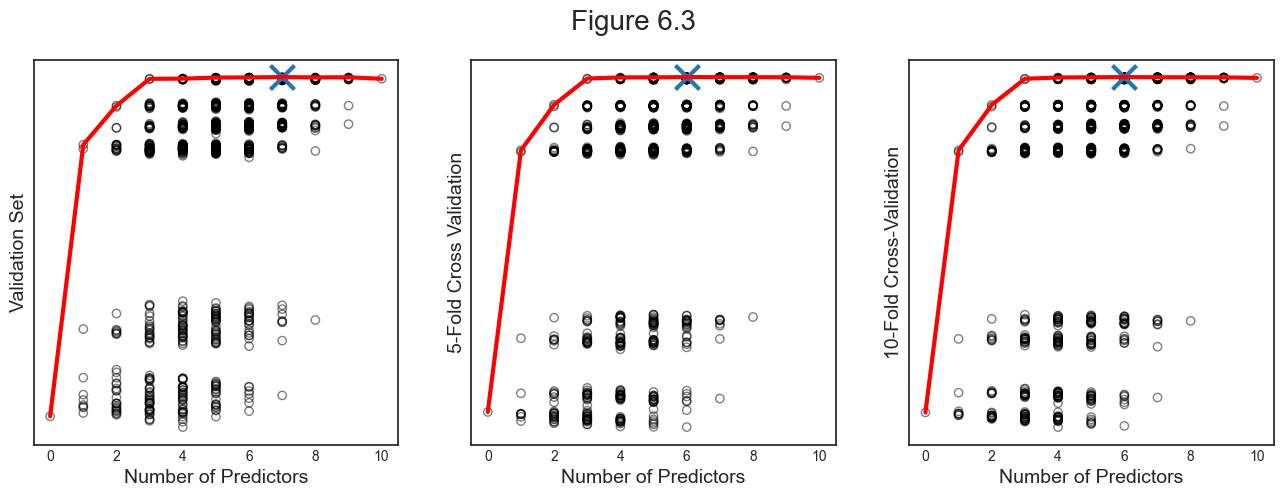

In [30]:
make_figure_6_3()

Na figura, vemos que cada método de validação cruzada seleciona um modelo diferente e o mais preciso, K-fold CV, seleciona 5 preditores.

### 5. Shrinkage Methods (Métodos de Encolhimento)

Os métodos de seleção de modelos restringiam o número de variáveis ​​antes de executar uma regressão linear. Os métodos de encolhimento tentam fazer as duas coisas simultaneamente. Em particular, eles restringem ou reduzem os coeficientes impondo penalidades nas funções objetivo para valores altos dos parâmetros.

### 5.1. Ridge Regression (Regressão de Ridge)

A regressão dos mínimos quadrados minimiza a soma residual dos quadrados

$$ RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2  = \sum_{i=1}^{n} (y_i - \hat{\beta}_0 - \hat{\beta}_1 x_{i1} - \hat{\beta}_2 x_{i2} - ... - \hat{\beta}_p x_{ip})^2 $$


A função objetivo da regressão de Ridge é

$$ RSS + \lambda \sum_{j=1}^{p} \hat{\beta}_j^2 $$


onde $\lambda>0$ é um parâmetro de ajuste que regula até que ponto parâmetros grandes são penalizados.

Na notação matricial, a função objetivo é

$$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$


o que é equivalente a otimizar

$$ \frac{1}{N} ||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$
 

Agora, executaremos a Regressão de Ridge no Creditconjunto de dados, tentando explicar a conta Balancecom um conjunto de características individuais observáveis.

In [31]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']
n = len(credit)

Executamos a regressão de crista em uma faixa de valores para o parâmetro de penalidade $\lambda$.

In [32]:
# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(-2,5,n_grid).reshape(-1,1)
ridge = Ridge()
ridge_coefs = []

# Loop over values of alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.reshape(ridge_coefs,(n_grid,-1))

Usamos regressão linear como comparação.

In [33]:
# OLS regression
ols = LinearRegression().fit(scale(X),y)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
rel_beta = [np.linalg.norm(ridge_coefs[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

Nós plotamos os resultados

In [34]:
# Figure 6.4
def make_figure_6_4():

    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.4: Ridge Regression Coefficients')

    highlight = [0,1,2,7];

    # Plot coefficients - absolute
    ax1.plot(alphas, ridge_coefs[:,highlight], alpha=1)
    ax1.plot(alphas, ridge_coefs, c='grey', alpha=0.3)
    ax1.set_xscale('log')
    ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
    ax1.legend(['Income', 'Limit', 'Rating', 'Student'])

    # Plot coefficients - relative
    ax2.plot(rel_beta, ridge_coefs[:,highlight], alpha=1)
    ax2.plot(rel_beta, ridge_coefs, c='grey', alpha=0.3)
    ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Standardized coefficients');

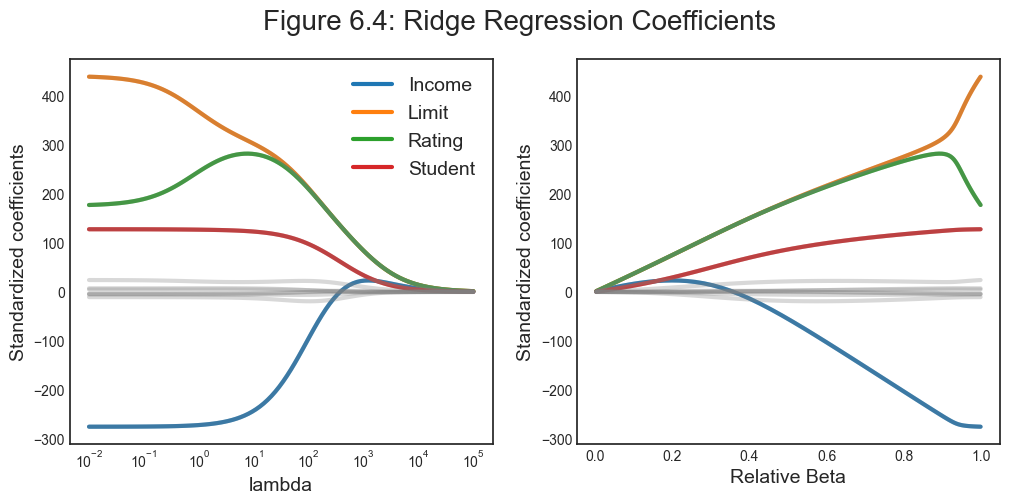

In [35]:
make_figure_6_4()

À medida que diminuímos $\lambda$, os coeficientes de Ridge aumentam. Além disso, as variáveis ​​com os coeficientes consistentemente maiores são Income, Limit, Ratinge Student.

### 5.2. Trade-off de viés-variância

A vantagem da regressão de crista sobre os mínimos quadrados está enraizada na compensação entre viés e variância.
$\lambda$ aumenta, a flexibilidade do ajuste de regressão de crista diminui, levando à diminuição da variância, mas ao aumento do viés.

$$ y_0 = f(x_0) + \epsilon $$

Recapitulação: podemos decompor o erro quadrático médio de um estimador em dois componentes: a variância e o viés quadrático :

$$ E[y_0 - \hat{f}(x_0)]^2 = E[(f(x_0) + \epsilon - \hat{f}(x_0))^2] = E[(f(x_0) - \hat{f}(x_0))^2] + E[\epsilon^2] + 2E[(f(x_0) - \hat{f}(x_0))\epsilon] $$

O último termo é a variância do termo de erro, às vezes também chamado de erro irredutível , pois é ruído puro e não podemos explicá-lo.

In [36]:
# Compute var-bias
def compute_var_bias(X_train, b0, x0, a, k, n, sim, f):
    
    # Init 
    y_hat = np.zeros(sim)
    coefs = np.zeros((sim, k))
    
    # Loop over simulations
    for s in range(sim):
        e_train = normal(0,1,(n,1))
        y_train = X_train @ b0 + e_train
        fit = f(a).fit(X_train, y_train)
        y_hat[s] = fit.predict(x0)
        coefs[s,:] = fit.coef_
        
    # Compute MSE, Var and Bias2   
    e_test = normal(0,1,(sim,1))
    y_test = x0 @ b0 + e_test
    mse = np.mean((y_test - y_hat)**2)
    var = np.var(y_hat)
    bias2 = np.mean(x0 @ b0 - y_hat)**2
    
    return [mse, var, bias2], np.mean(coefs, axis=0)

In [37]:
np.random.seed(1)

# Generate random data
n = 50
k = 45
N = 50000
X_train = normal(0.2,1,(n,k))
x0 = normal(0.2,1,(1,k))
e_train = normal(0,1,(n,1))
b0 = uniform(0,1,(k,1))

In [38]:
# Init alpha grid
sim = 1000
n_grid = 30
df = pd.DataFrame({'alpha':10**np.linspace(-5,5,n_grid)})
ridge_coefs2 = []

# Init simulations
sim = 1000
ridge = lambda a: Ridge(alpha=a, fit_intercept=False)

# Loop over values of alpha
for i in range(len(df)):
    print("Alpha %1.0f/%1.0f" % (i+1,len(df)), end ="")
    a = df.loc[i,'alpha']
    df.loc[i,['mse','var','bias2']], c = compute_var_bias(X_train, b0, x0, a, k, n, sim, ridge)
    ridge_coefs2.append(c)
    print("", end="\r")
ridge_coefs2 = np.reshape(ridge_coefs2,(n_grid,-1))

In [39]:
# OLS regression
y_train = X_train @ b0 + e_train
ols = LinearRegression().fit(X_train,y_train)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
rel_beta = [np.linalg.norm(ridge_coefs2[i,:])/mod_ols for i in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [40]:
# Figure 6.5
def make_figure_6_5():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.5: Ridge Bias-Var decomposition')

    # MSE
    ax1.plot(df['alpha'], df[['bias2','var','mse']]);
    ax1.set_xscale('log');
    ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
    ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

    # MSE
    ax2.plot(rel_beta, df[['bias2','var','mse']]);
    ax2.set_xlabel('Relative Beta'); ax2.set_ylabel('Mean Squared Error');
    ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

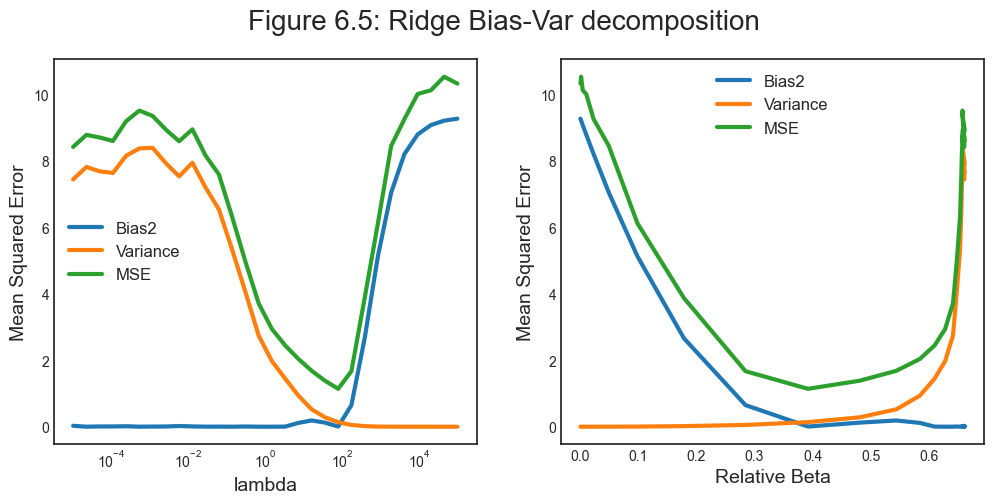

In [41]:
make_figure_6_5()

A regressão de crista tem a vantagem de reduzir os coeficientes. No entanto, ao contrário da seleção do melhor subconjunto, da seleção passo a passo para frente e da seleção passo a passo para trás, que geralmente selecionam modelos que envolvem apenas um subconjunto das variáveis, a regressão de crista incluirá todas as variáveis. $p$
preditores no modelo final.

O Lasso resolve esse problema usando uma função de penalidade diferente.

### 5.4. Lasso (Laço)

Os coeficientes do LASSO minimizam a seguinte função objetivo:

$$ 


de modo que a principal diferença em relação à regressão de crista é a função de penalidade
em vez de
.

Uma consequência dessa função objetivo é que Lasso tem muito mais probabilidade de reduzir os coeficientes a exatamente zero, enquanto Ridge apenas diminui sua magnitude. A razão para isso reside na forma da função objetivo. Você pode reescrever os problemas de minimização de Ridge e Lasso como otimização restrita:

Cume
\underset{\beta}{\operatorname{min}} \ \esquerda{\sum_{i=1}^{n}\esquerda(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{ij}\direita)^{2}\direita} \quad \texto { sujeito a } \quad \sum_{j=1}^{p}\esquerda|\beta_{j}\direita| \leq s

Laço
\underset{\beta}{\operatorname{min}} \ \esquerda{\sum_{i=1}^{n}\esquerda(y_{i}-\beta_{0}-\sum_{j=1}^{p} \beta_{j} x_{ij}\direita)^{2}\direita} \quad \texto { sujeito a } \quad \sum_{j=1}^{p} \beta_{j}^{2} \leq s

Nas imagens, o problema de otimização restrita se parece com isso.

Desenho
As curvas vermelhas representam os conjuntos de contornos do RSS. Elas são elípticas, visto que a função objetivo é quadrática. A área azul representa o conjunto admissível, ou seja, as restrições. Como podemos ver, é muito mais fácil com Lasso ter o ótimo restrito em uma das arestas do losango.

Vamos agora repetir o mesmo exercício no Creditconjunto de dados, tentando prever a conta Balancecom um conjunto de características individuais observáveis, para diferentes valores do parâmetro de penalidade

In [42]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = credit.loc[:,'Balance']

O $\lambda$ a grade será um pouco diferente agora.

In [44]:
# Init alpha grid
n_grid = 100
alphas = 10 ** np.linspace(0, 3, n_grid)  # Sem reshape

lasso = Lasso(max_iter=10000)  # Garantia de convergência
lasso_coefs = []

# Loop over values of alpha
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X), y)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.reshape(lasso_coefs, (n_grid, -1))

Executamos o OLS para traçar a magnitude relativa dos coeficientes do Lasso.

In [45]:
# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(lasso_coefs[i,:])/mod_ols for i in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

Traçamos a magnitude dos coeficientes $\beta$ 
* para diferentes valores de $\lambda$.
* para diferentes valores de $||\beta||$.

In [46]:
# Figure 6.6
def make_figure_6_6():

    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.6')

    highlight = [0,1,2,7];

    # Plot coefficients - absolute
    ax1.plot(alphas, lasso_coefs[:,highlight], alpha=1)
    ax1.plot(alphas, lasso_coefs, c='grey', alpha=0.3)
    ax1.set_xscale('log')
    ax1.set_xlabel('lambda'); ax1.set_ylabel('Standardized coefficients');
    ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

    # Plot coefficients - relative
    ax2.plot(rel_beta, lasso_coefs[:,highlight], alpha=1)
    ax2.plot(rel_beta, lasso_coefs, c='grey', alpha=0.3)
    ax2.set_xlabel('relative mod beta'); ax2.set_ylabel('Standardized coefficients');

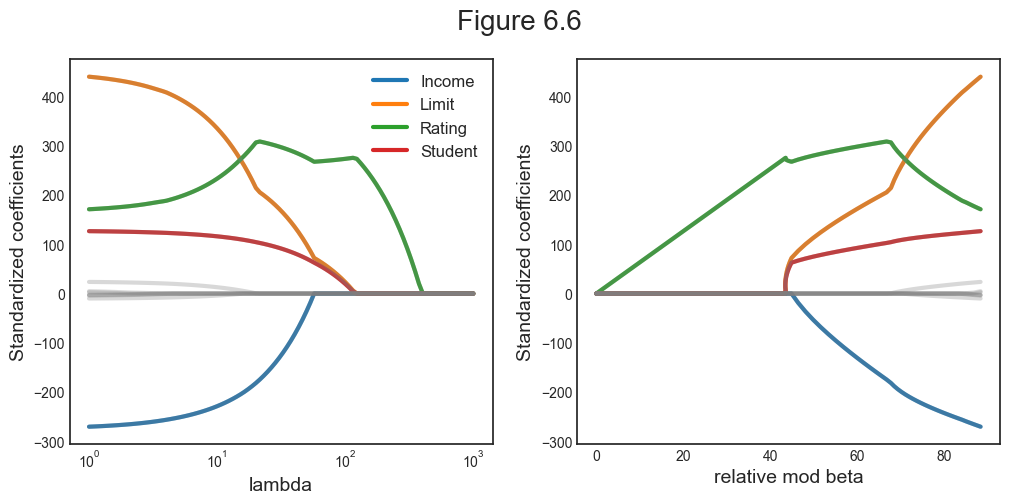

In [47]:
make_figure_6_6()

`Rating`parece ser a variável mais importante, seguida por `Limit` e `Student`.

Tal como na regressão de crista, o laço reduz as estimativas dos coeficientes para zero. No entanto, no caso do laço, $l_{1}$ a penalidade tem o efeito de forçar algumas das estimativas de coeficientes a serem exatamente iguais a zero quando o parâmetro de ajuste $\lambda$ é suficientemente grande. Portanto, assim como a seleção do melhor subconjunto, o laço realiza a seleção de variáveis.

Dizemos que o laço produz modelos ***esparsos*** — isto é, modelos que envolvem apenas um subconjunto da variável

Agora traçamos como a escolha de $\lambda$ afeta o trade-off de viés-variância.

In [48]:
# Init alpha grid
sim = 1000
n_grid = 30
df = pd.DataFrame({'alpha':10**np.linspace(-1,1,n_grid)})
lasso_coefs2 = []

# Init simulations
sim = 1000
lasso = lambda a: Lasso(alpha=a, fit_intercept=False)

# Loop over values of alpha
for i in range(len(df)):
    print("Alpha %1.0f/%1.0f" % (i+1,len(df)), end ="")
    a = df.loc[i,'alpha']
    df.loc[i,['mse','var','bias2']], c = compute_var_bias(X_train, b0, x0, a, k, n, sim, lasso)
    lasso_coefs2.append(c)
    print("", end="\r")
lasso_coefs2 = np.reshape(lasso_coefs2,(n_grid,-1))

In [49]:
# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(lasso_coefs2[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [50]:
# OLS regression
y_train = X_train @ b0 + e_train
ols = LinearRegression().fit(X_train,y_train)
ols_coefs = ols.coef_;
mod_ols = np.linalg.norm(ols_coefs)

# Relative magnitude
mod_ols = np.linalg.norm(ols_coefs)
rel_beta = [np.linalg.norm(lasso_coefs2[k,:])/mod_ols for k in range(n_grid)]
rel_beta = np.reshape(rel_beta, (-1,1))

In [51]:
# Figure 6.8
def make_figure_6_8():

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    fig.suptitle('Figure 6.8: Lasso Bias-Var decomposition')

    # MSE
    ax1.plot(df['alpha'], df[['bias2','var','mse']]);
    ax1.set_xscale('log');
    ax1.set_xlabel('lambda'); ax1.set_ylabel('Mean Squared Error');
    ax1.legend(['Bias2','Variance','MSE'], fontsize=12);

    # MSE
    ax2.plot(rel_beta, df[['bias2','var','mse']]);
    ax2.set_xlabel('Relative Beta'); ax1.set_ylabel('Mean Squared Error');
    ax2.legend(['Bias2','Variance','MSE'], fontsize=12);

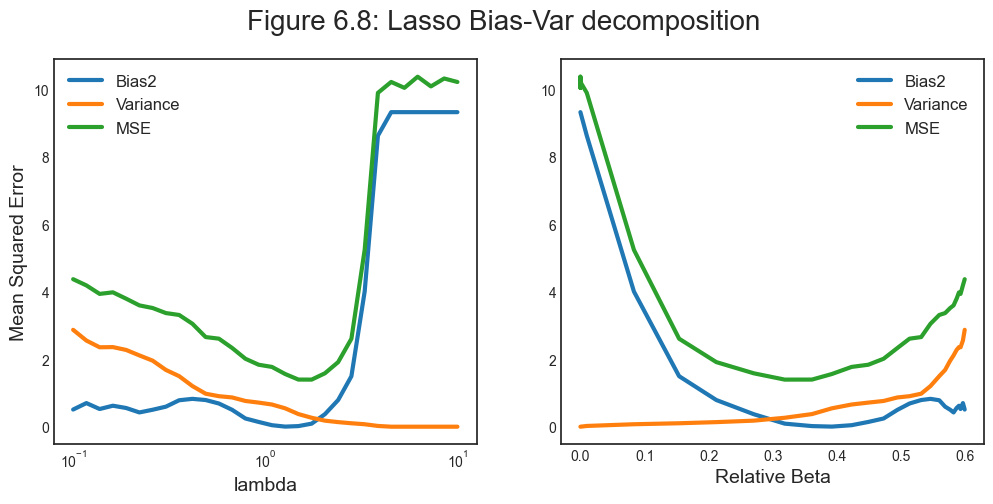

In [52]:
make_figure_6_8()

Como $\lambda$ aumenta o viés quadrado aumenta e a variância diminui.

### 5.5. Comparando a regressão Lasso e Ridge

Para obter uma melhor intuição sobre o comportamento da regressão de crista e do laço, considere um caso especial simples com $n=p$, e $X$ uma matriz diagonal com $1$ na diagonal e $0$ em todos os elementos fora da diagonal. Para simplificar ainda mais o problema, considere também que estamos realizando uma regressão sem interceptação.

Com essas suposições, o problema usual dos mínimos quadrados simplifica-se para os coeficientes que minimizam

$$ \sum_{j=1}^{p} (y_{j}-\beta_{j})^{2} $$

Neste caso, a solução dos mínimos quadrados é dada por

$$ \hat{\beta}_{j}=y_{j} $$

Pode-se mostrar que, neste cenário, as estimativas de regressão de crista assumem a forma

$$ \hat{\beta}_{j}^{Ridge}=\left(\frac{y_{j}}{1+\lambda}\right) $$
 

e as estimativas do laço assumem a forma

$$
\hat{\beta}_{j}^{LASSO} = 
\begin{cases}
y_{j} - \lambda/2 & \text{se } y_{j} > \lambda/2 \\
y_{j} + \lambda/2 & \text{se } y_{j} < -\lambda/2 \\
0 & \text{se } |y_{j}| \leq \lambda/2
\end{cases}
$$


Nós traçamos o relacionamento visualmente.

In [53]:
np.random.seed(3)

# Generate random data
n = 100
k = n
X = np.eye(k)
e = normal(0,1,(n,1))
b0 = uniform(-1,1,(k,1))
y = X @ b0 + e

In [54]:
# OLS regression
reg = LinearRegression().fit(X,y)
ols_coefs = reg.coef_;

# Ridge regression
ridge = Ridge(alpha=1).fit(X,y)
ridge_coefs = ridge.coef_;

# Ridge regression
lasso = Lasso(alpha=0.01).fit(X,y)
lasso_coefs = lasso.coef_.reshape(1,-1);

# sort
order = np.argsort(y.reshape(1,-1), axis=1)
y_sorted = np.take_along_axis(ols_coefs, order, axis=1) 
ols_coefs = np.take_along_axis(ols_coefs, order, axis=1) 
ridge_coefs = np.take_along_axis(ridge_coefs, order, axis=1) 
lasso_coefs = np.take_along_axis(lasso_coefs, order, axis=1) 

In [55]:
# Figure 6.10
def make_figure_6_10():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.10')

    # Ridge
    ax1.plot(y_sorted.T, ols_coefs.T)
    ax1.plot(y_sorted.T, ridge_coefs.T)
    ax1.set_xlabel('True Coefficient'); ax1.set_ylabel('Estimated Coefficient');
    ax1.legend(['OLS','Ridge'], fontsize=12);

    # Lasso
    ax2.plot(y_sorted.T, ols_coefs.T)
    ax2.plot(y_sorted.T, lasso_coefs.T)
    ax2.set_xlabel('True Coefficient'); ax2.set_ylabel('Estimated Coefficient');
    ax2.legend(['OLS','Lasso'], fontsize=12);

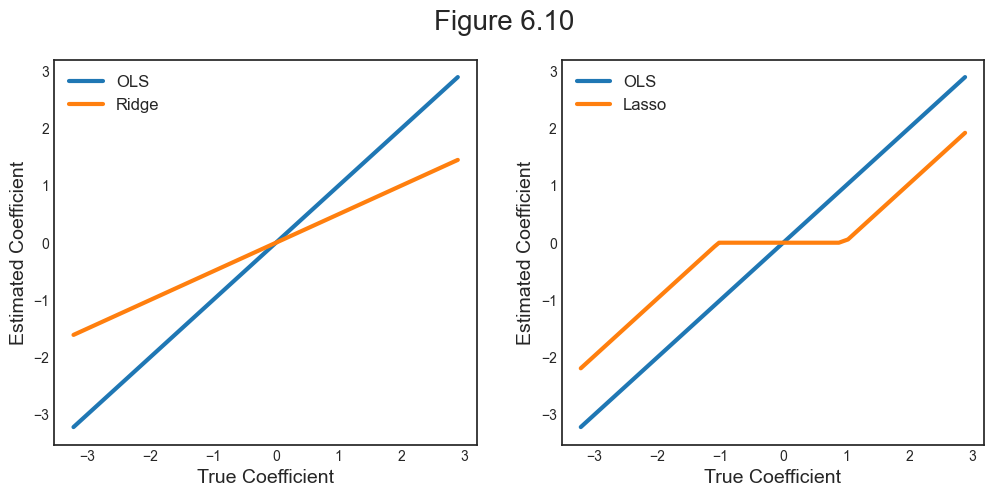

In [56]:
make_figure_6_10()

Vemos que a regressão de crista reduz todas as dimensões dos dados na mesma proporção, enquanto o laço reduz todos os coeficientes em direção a zero em uma quantidade similar, e coeficientes suficientemente pequenos são reduzidos até zero.

### 5.6. Selecionando o parâmetro de ajuste

A implementação da regressão de crista e do Lasso requer um método para selecionar um valor para o parâmetro de ajuste $\lambda$.

A validação cruzada oferece uma maneira simples de resolver esse problema. Escolhemos uma grade de $\lambda$
valores e calcular o erro de validação cruzada para cada valor de $\lambda$. Em seguida, selecionamos o valor do parâmetro de ajuste para o qual o erro de validação cruzada é o menor. Por fim, o modelo é reajustado usando todas as observações disponíveis e o valor selecionado do parâmetro de ajuste.

In [57]:
# X and y
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = credit.loc[:, credit.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True).values
y = credit.loc[:,'Balance']
n = len(credit)

Usaremos o CV de 10 vezes como algoritmo de validação cruzada.

In [64]:
def cv_lasso(X, y, a):
    # Init mse
    mse = []
    
    # Generate splits
    kf10 = KFold(n_splits=10, random_state=None, shuffle=False)
    
    # Loop over splits
    for train_index, test_index in kf10.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        lasso = Lasso(alpha=a, max_iter=10000).fit(X_train, y_train)
        y_hat = lasso.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    
    return np.mean(mse)

In [65]:
# Compute MSE over grid of alphas
n_grid = 30
alphas = 10 ** np.linspace(0, 3, n_grid)  # CORRETO: shape (30,)

MSE = [cv_lasso(scale(X), y.values, a) for a in alphas]

Qual é o $\lambda$ ideal?

In [67]:
# Find minimum alpha
alpha_min = alphas[np.argmin(MSE)]
print('Best alpha by 10fold CV:',alpha_min)

Best alpha by 10fold CV: 1.0


Agora plotamos a função objetivo e os coeficientes implícitos $\lambda$ no ponto ótimo.

In [68]:
# Get coefficients
coefs = []

# Loop over values of alpha
for a in alphas:
    lasso = Lasso(alpha=a).fit(scale(X), y)
    coefs.append(lasso.coef_)
coefs = np.reshape(coefs,(n_grid,-1))

In [69]:
# Figure 6.12
def make_figure_6_12():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.suptitle('Figure 6.12: Lasso 10-fold CV')

    # MSE by LOO CV
    ax1.plot(alphas, MSE, alpha=1);
    ax1.axvline(alpha_min, c='k', ls='--')
    ax1.set_xscale('log')
    ax1.set_xlabel('lambda'); ax1.set_ylabel('MSE');

    highlight = [0,1,2,7];

    # Plot coefficients - absolute
    ax2.plot(alphas, coefs[:,highlight], alpha=1)
    ax2.plot(alphas, coefs, c='grey', alpha=0.3)
    ax2.axvline(alpha_min, c='k', ls='--')
    ax2.set_xscale('log')
    ax2.set_xlabel('lambda'); ax2.set_ylabel('Standardized coefficients');
    ax2.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=10);

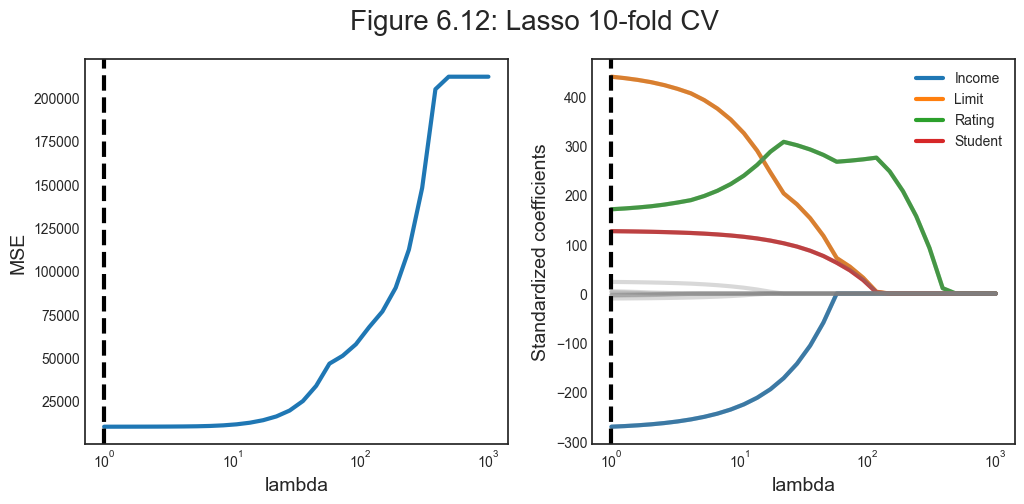

In [70]:
make_figure_6_12()